In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

Part 0 : Data Creation

In [ ]:
def generate_data_part0(n_class0=150, n_class1=50):
    """  
    Returns:
    - X: feature matrix
    - y: class labels
    """
    # Class 0: Uniform distribution across 3 squares
    class0_points = []
    
    # Square 1: [-1, 0] x [-1, 0]
    square1 = np.random.uniform(low=[-1, -1], high=[0, 0], size=(n_class0//3, 2))
    
    # Square 2: [-1, 0] x [0, 1]
    square2 = np.random.uniform(low=[-1, 0], high=[0, 1], size=(n_class0//3, 2))
    
    # Square 3: [0, 1] x [-1, 0]
    square3 = np.random.uniform(low=[0, -1], high=[1, 0], size=(n_class0 - 2*(n_class0//3), 2))
    
    class0_points = np.vstack([square1, square2, square3])
    
    # Class 1: Gaussian distribution
    class1_points = np.random.normal(loc=[0.5, 0.5], 
                                     scale=[0.5, 0.5], 
                                     size=(n_class1, 2))
    
    # Combine data
    X = np.vstack([class0_points, class1_points])
    y = np.hstack([np.zeros(n_class0), np.ones(n_class1)])
    
    return X, y

In [ ]:
X, y = generate_data_part0()

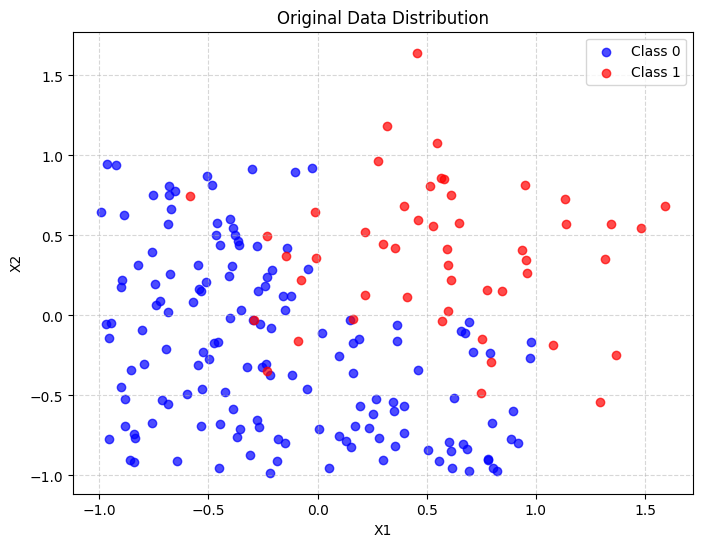

In [5]:
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], 
                c='blue', label='Class 0', alpha=0.7)
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], 
                c='red', label='Class 1', alpha=0.7)
plt.title('Original Data Distribution')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Split data into training and testing sets

In [6]:
np.random.seed(42)
indices = np.random.permutation(len(X))
split_point = len(X) // 2
    
X_train, X_test = X[indices[:split_point]], X[indices[split_point:]]
y_train, y_test = y[indices[:split_point]], y[indices[split_point:]]

In [14]:
def evaluate_classifier(X, y, classifier, cv=4):
    """
    Evaluate classifier using 4-fold cross-validation
    
    Returns:
    - Metrics dictionary
    - Accuracy scores for variance calculation
    """
    # Stratified K-Fold for balanced splits
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    # Metrics to track
    accuracies = []
    precisions = []
    recalls = []
    aurocs = []
    
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Fit classifier
        classifier.fit(X_train_scaled, y_train)
        y_pred = classifier.predict(X_test_scaled)
        
        # Compute metrics
        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred, zero_division=1))
        recalls.append(recall_score(y_test, y_pred, zero_division=1))
        
        # AUROC 
        y_decision = classifier.decision_function(X_test_scaled)
        aurocs.append(roc_auc_score(y_test, y_decision))
    
    # Compute average metrics
    metrics = {
        'accuracy': np.mean(accuracies),
        'precision': np.mean(precisions),
        'recall': np.mean(recalls),
        'auroc': np.mean(aurocs),
        'accuracy_variance': np.var(accuracies)
    }
    
    return metrics, accuracies

In [11]:
from sklearn.linear_model import Perceptron

Part 1 : Perceptron

In [15]:
perceptron = Perceptron(max_iter=1000, random_state=42)
perceptron_metrics, perceptron_accuracies = evaluate_classifier(X_train, y_train, perceptron)
print("Perceptron Metrics:", perceptron_metrics)

Perceptron Metrics: {'accuracy': np.float64(0.81), 'precision': np.float64(0.6414141414141414), 'recall': np.float64(0.7916666666666667), 'auroc': np.float64(0.910438596491228), 'accuracy_variance': np.float64(0.0035000000000000005)}


Part 2A: Linear SVM (Small C)

In [16]:
svm_small_c = SVC(kernel='linear', C=0.01, random_state=42, probability=True)
svm_small_c_metrics, svm_small_c_accuracies = evaluate_classifier(X_train, y_train, svm_small_c)
print("Linear SVM (Small C) Metrics:", svm_small_c_metrics)

Linear SVM (Small C) Metrics: {'accuracy': np.float64(0.77), 'precision': np.float64(1.0), 'recall': np.float64(0.0), 'auroc': np.float64(0.915438596491228), 'accuracy_variance': np.float64(0.00030000000000000057)}


Notes: 
- Perfect precision (1.0)
- Zero recall (0.0)
- High AUROC (0.9154), suggests that the model is extremely conservative, avoiding false positives at the cost of missing all positive samples, high AUROC indicates it can distinguish between classes, but it's choosing to classify everything as negative

- typically due to having small value of C which prioritized a simple decision boundary over capturing all positive samples.

Part 2B: Linear SVM (Large C)

In [17]:
svm_large_c = SVC(kernel='linear', C=1000, random_state=42, probability=True)
svm_large_c_metrics, svm_large_c_accuracies = evaluate_classifier(X_train, y_train, svm_large_c)
print("Linear SVM (Large C) Metrics:", svm_large_c_metrics)

Linear SVM (Large C) Metrics: {'accuracy': np.float64(0.88), 'precision': np.float64(0.8333333333333333), 'recall': np.float64(0.6583333333333333), 'auroc': np.float64(0.9110526315789473), 'accuracy_variance': np.float64(0.0008000000000000014)}


Part 3A: Nonlinear SVM (Small C)

In [18]:
svm_nonlinear_small_c = SVC(kernel='rbf', C=0.01, random_state=42, probability=True)
svm_nonlinear_small_c_metrics, svm_nonlinear_small_c_accuracies = evaluate_classifier(X_train, y_train, svm_nonlinear_small_c)
print("Nonlinear SVM (Small C) Metrics:", svm_nonlinear_small_c_metrics)

Nonlinear SVM (Small C) Metrics: {'accuracy': np.float64(0.77), 'precision': np.float64(1.0), 'recall': np.float64(0.0), 'auroc': np.float64(0.9019736842105263), 'accuracy_variance': np.float64(0.00030000000000000057)}


Part 3B: Nonlinear SVM (Large C)

In [19]:
svm_nonlinear_large_c = SVC(kernel='rbf', C=1000, random_state=42, probability=True)
svm_nonlinear_large_c_metrics, svm_nonlinear_large_c_accuracies = evaluate_classifier(X_train, y_train, svm_nonlinear_large_c)
print("Nonlinear SVM (Large C) Metrics:", svm_nonlinear_large_c_metrics)

Nonlinear SVM (Large C) Metrics: {'accuracy': np.float64(0.8), 'precision': np.float64(0.691468253968254), 'recall': np.float64(0.5249999999999999), 'auroc': np.float64(0.7901754385964913), 'accuracy_variance': np.float64(0.0032000000000000015)}


Part 3C: Increased Class 1 Variance

In [20]:
X_high_var, y_high_var = generate_data_part0(n_class0=150, n_class1=50)


In [21]:
np.random.seed(42)
indices_high_var = np.random.permutation(len(X_high_var))
split_point_high_var = len(X_high_var) // 2

In [22]:
X_train_high_var = X_high_var[indices_high_var[:split_point_high_var]]
y_train_high_var = y_high_var[indices_high_var[:split_point_high_var]]
    
svm_reasonable_c = SVC(kernel='rbf', C=10, random_state=42, probability=True)
svm_reasonable_c_metrics, svm_reasonable_c_accuracies = evaluate_classifier(X_train_high_var, y_train_high_var, svm_reasonable_c)
print("Nonlinear SVM (Reasonable C) Metrics:", svm_reasonable_c_metrics)

Nonlinear SVM (Reasonable C) Metrics: {'accuracy': np.float64(0.91), 'precision': np.float64(0.9375), 'recall': np.float64(0.6499999999999999), 'auroc': np.float64(0.7977631578947368), 'accuracy_variance': np.float64(0.0035000000000000014)}


Part 4: Mismatch between Training and Test Data

In [23]:
def generate_mismatched_data(n_class0=150, n_class1=50):
    # Modified Class 0 distribution
    class0_points = np.random.uniform(low=[-0.5, -0.5], high=[1, 0.5], size=(n_class0, 2))
    
    # Gaussian Class 1 with increased variance
    class1_points = np.random.normal(loc=[0.5, 0.5], 
                                     scale=[1.5, 1.5], 
                                     size=(n_class1, 2))
    
    X = np.vstack([class0_points, class1_points])
    y = np.hstack([np.zeros(n_class0), np.ones(n_class1)])
    
    return X, y

In [24]:
X_mismatch, y_mismatch = generate_mismatched_data()

In [25]:
svm_mismatch = SVC(kernel='rbf', C=10, random_state=42, probability=True)
svm_mismatch_metrics, svm_mismatch_accuracies = evaluate_classifier(X_mismatch, y_mismatch, svm_mismatch)
print("Nonlinear SVM (Mismatched Data) Metrics:", svm_mismatch_metrics)

Nonlinear SVM (Mismatched Data) Metrics: {'accuracy': np.float64(0.96), 'precision': np.float64(1.0), 'recall': np.float64(0.8445512820512819), 'auroc': np.float64(0.9290643122879966), 'accuracy_variance': np.float64(0.0009999999999999996)}


Part 5: High Variance with Reduced Training Set

In [26]:
X_reduced, y_reduced = generate_data_part0(n_class0=60, n_class1=20)

In [27]:
svm_reduced = SVC(kernel='rbf', C=10, random_state=42, probability=True)
svm_reduced_metrics, svm_reduced_accuracies = evaluate_classifier(X_reduced, y_reduced, svm_reduced)

In [28]:
print("Nonlinear SVM (Reduced Training Set) Metrics:", svm_reduced_metrics)

Nonlinear SVM (Reduced Training Set) Metrics: {'accuracy': np.float64(0.9249999999999999), 'precision': np.float64(0.95), 'recall': np.float64(0.75), 'auroc': np.float64(0.8733333333333333), 'accuracy_variance': np.float64(0.001874999999999999)}
